
<center>
    <h1 style="color:deeppink">Just between us SQL Friends...</h1>
    <h2 style="color:deeppink">RuPaul's Drag Race: Visualized</h2>
    <img src="media/header.gif" height="100px">
</center>

<h2 style="color:deeppink">Check Dependencies, Import Libraries, and Connect SQLite Database</h2>

In [1]:
from helper import *

try:
    import pandas as pd
    from pandas.io.json import json_normalize
except ImportError as e:
    pass

try:
    import sqlite3
except ImportError as e:
    pass

try:
    import matplotlib.pyplot as plt
except ImportError as e:
    pass

try:
    from bokeh.plotting import ColumnDataSource, figure, show, output_notebook
except ImportError as e:
    pass

In [2]:
drag_race_data_base = sqlite3.connect("drag_race_data.db")

<h2 style="color:deeppink">Define Constants, Global Variables, and API endpoints</h2>

In [3]:
DRAG_RACE_API_URL = "http://www.nokeynoshade.party/api/"

#API Endpoints
QUEENS = "queens/all"
SEASONS = "seasons"
SEASON_BY_NUMBER = "seasons/{}"
ALL_CHALLENGES = "challenges"
CHALLENGE_BY_NUMBER = "challenges/{}"
CHALLENGES_BY_QUEEN_ID = "queens/{}/challenges"
CHALLENGES_BY_SEASON = "seasons/{}/challenges"

<h2 style="color:deeppink">Define Functions</h2>

In [4]:
#some, not all, api endpoints require a season_id number... we'll make that argument optional.
def get_data(endpoint, SEASON = None):
    df = pd.read_json(DRAG_RACE_API_URL + endpoint.format(SEASON))
    return df


def get_seasons():
    df = pd.DataFrame()
    temp_df = pd.DataFrame()
    for i in range(len(season_id_df)):
        temp_df = get_data(SEASON_BY_NUMBER, i +1)
        temp_df = json_normalize(temp_df['queens'])
        temp_df['season_id'] = i + 1
        df = pd.concat([df, temp_df], sort=False)
        i += 1
    return df


def get_challenges():
    df = pd.DataFrame()
    temp_df = pd.DataFrame()
    for i in range(15):
        temp_df = get_data(CHALLENGES_BY_SEASON, i + 1)
        temp_df['season_id'] = i + 1
        df = pd.concat([df, temp_df], sort=False)
        i += 1
    return df


def get_image_urls(data_set):
    images = []
    for i in range(len(data_set['image_url'])):
        images.append(Image(url = data_set['image_url'][i], width = 50))
        i += 1
    return images


def display_images(images):
    for image in images:
        display(image)
        

<h2 style="color:deeppink">Define SQL Queries</h2>

In [5]:
SELECT_QUEENS = """
    SELECT queens.id, name, season_number, place, winner, missCongeniality AS miss_congeniality, image_url, quote FROM seasons
    INNER JOIN season_ids ON seasons.season_id = season_ids.season_id
    INNER JOIN queens ON seasons.id = queens.id
"""

all_queens_query = SELECT_QUEENS + """
    ORDER BY season_number, place DESC
"""


all_stars_query = SELECT_QUEENS + """
    WHERE season_number LIKE "%A%"
    ORDER BY season_number, place DESC
"""


main_seasons_query = SELECT_QUEENS + """
    WHERE season_number NOT LIKE "A%" 
    ORDER BY season_number, place DESC
"""


main_season_winners_query = SELECT_QUEENS + """
    WHERE winner IS True AND season_number NOT LIKE "A%" AND place = 1
"""


all_stars_winners_query = SELECT_QUEENS + """
    WHERE season_number LIKE "A%" AND place = 1
"""


miss_congeniality_query = SELECT_QUEENS + """
    WHERE missCongeniality IS True
    ORDER BY season_id"""

main_challenge_wins_query = """
    SELECT name, count(won) AS wins
    FROM challenges
    WHERE won IS True
    GROUP BY name
    ORDER BY wins DESC
    LIMIT 10
"""

all_stars_performance_query = """
    SELECT main_seasons_queens.id, 
            main_seasons_queens.name, 
            main_seasons_queens.season_number AS "Main Season Number", 
            main_seasons_queens.place AS "Main Season Place", 
            all_stars_queens.season_number AS "All Stars Season Number",
            all_stars_queens.place AS "All Stars Place",
            main_seasons_queens.image_url,
            main_seasons_queens.quote
    FROM main_seasons_queens
    INNER JOIN all_stars_queens ON main_seasons_queens.id = all_stars_queens.id
"""

<h2 style="color:deeppink">Define values used for cleanup</h2>

In [6]:
queens_drop_cols = ['queens', 'name']

<h2 style="color:deeppink">Create raw dataframes from API endpoints</h2>

In [7]:
raw_seasons_df = get_data(SEASONS)
raw_queens_df = get_data(QUEENS)

# create season_id_df to look up season numbers by id
season_id_df = pd.DataFrame({"season_id": raw_seasons_df['id'], "season_number": raw_seasons_df['seasonNumber']})

<h2 style="color:deeppink">Create SQL Tables</h2>

In [8]:
# queens table
raw_queens_df.to_sql('queens', drag_race_data_base, if_exists='replace')

# seasons table
seasons_df = get_seasons().set_index('id').drop(queens_drop_cols, axis=1)
seasons_df.to_sql('seasons', drag_race_data_base, if_exists = 'replace')

# season_ids table
season_id_df.to_sql('season_ids', drag_race_data_base, if_exists='replace')

#challenges table
main_challenges = get_challenges()[get_challenges().type.eq('main')]
json_normalize(main_challenges['queens'].explode()).to_sql('challenges', drag_race_data_base, if_exists="replace")

<h2 style="color:deeppink">Create DataFrames from the SQL Tables</h2>

In [9]:
#FIX THE SORTING FOR main_seasons... needs to be sorted by season ascending, then place descending. 
# the dtype change is what is causing the trouble

#all queens, ranked
main_seasons_df = pd.read_sql(main_seasons_query, drag_race_data_base).astype({'season_number':'int32'}).sort_values(by=['season_number']).set_index('id')
all_stars_df = pd.read_sql(all_stars_query, drag_race_data_base).sort_values(by=['season_number'])

#winners
main_season_winners_df = pd.read_sql(main_season_winners_query, drag_race_data_base).astype({'season_number':'int32'}).sort_values(by=['season_number'])
all_stars_winners_df = pd.read_sql(all_stars_winners_query, drag_race_data_base).sort_values(by=['season_number'])
#for some reason, Trinity and Monet X Change are not marked as AS 4 winners... The shade...
all_stars_winners_df['winner'] = 1

#most main challenge wins
top_ten_main_challenge_wins_df = pd.read_sql(main_challenge_wins_query, drag_race_data_base)


#queens performance in all stars as related to their main season performance
all_stars_performance_df = pd.read_sql(all_stars_performance_query, drag_race_data_base)

<h2 style="color:deeppink">Create more specific SQL Tables</h2>

In [10]:
# all_stars_winners_df.to_sql('all_stars_winners', drag_race_data_base, if_exists='replace')
main_seasons_df.to_sql('main_seasons_queens', drag_race_data_base, if_exists='replace')
all_stars_df.to_sql('all_stars_queens', drag_race_data_base, if_exists='replace')

<h2 style="color:deeppink">Bring back my girls...</h2>

<b style="color:deeppink">Display photos of Main Season winners</b>

In [11]:
# #TO DO: I'd like to show all of the images, but can this be done inline? Research says subplots may be a good answer
display_images(get_image_urls(main_season_winners_df))

<h2 style="color:deeppink">Bring back my All Stars...</h2>
<b style="color:deeppink">Display photos of All Stars season winners</b>

In [12]:
# #TO DO: I'd like to show all of the images, but can this be done inline? Research says subplots may be a good answer
display_images(get_image_urls(all_stars_winners_df))

<h2 style="color:deeppink">The Winners' Circle</h2>
<b style="color:deeppink">Show the number of Main Challenge Wins for the Top 10 Queens </b>

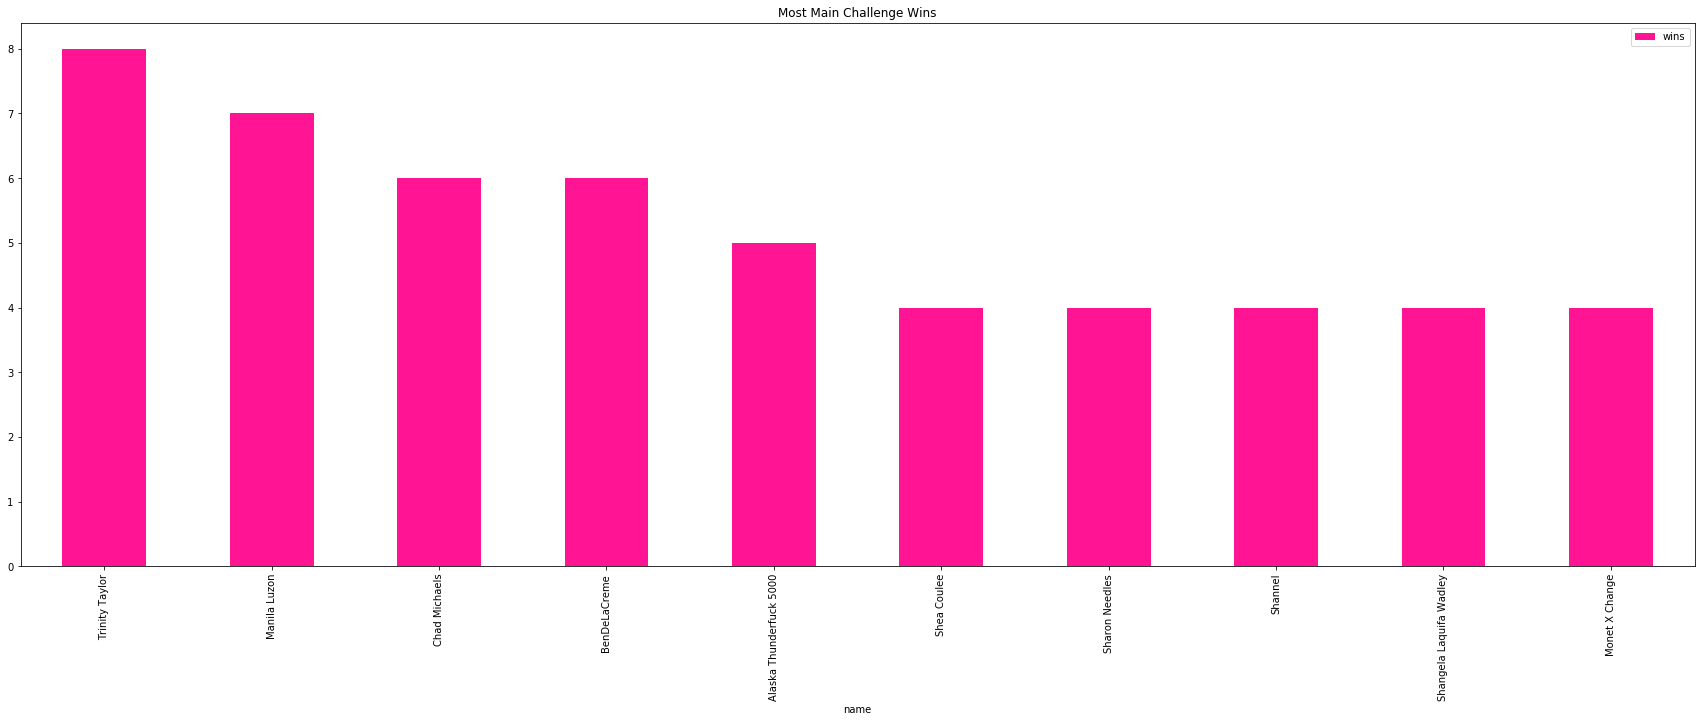

In [13]:
top_ten_main_challenge_wins_df.plot.bar(x="name", y="wins", color="deeppink", figsize=(30, 10), title="Most Main Challenge Wins")

<h2 style="color:deeppink">How'd they do?</h2>
<b style="color:deeppink">Use a Bokeh scatter plot to show the relationship between a queen's place in their Main Season and their place in All Stars</b>

In [14]:
TOOLTIP = """
    <div>
        <div>
            <img
                src="@imgs" alt="@imgs" width="100"
                style=" margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold; color:deeppink">@name</span>
        </div>
        <div style="width:150px">
            <span style="font-size: 10px; color: deeppink;">Season @season: $x{0}</span><br/>
            <span style="font-size: 10px; color: deeppink;">All Stars @as_season: $y{0}</span><br />
        </div>
    </div>
"""

TOOLS = []

In [15]:
df = all_stars_performance_df
source = ColumnDataSource(data=dict(
    x = df["Main Season Place"].astype('int8'), 
    y = df["All Stars Place"].astype('int8'),
    name=list(df['name']),
    imgs=list(df['image_url']),
    quote=list(df['quote']),
    season=list(df['Main Season Number']),
    as_season=list(df['All Stars Season Number'])
))

p = figure(plot_width=800, plot_height=800, 
           tooltips=TOOLTIP,
           title="Main Season Performance vs. All Stars Performance", 
           tools = TOOLS, background_fill_color="#FF8ADA", 
           x_axis_label='Main Season Place', 
           y_axis_label='All Stars Place',
           outline_line_dash_offset=1)

p.scatter('x', 'y', fill_color="darkviolet", size=15, fill_alpha=0.75,
          line_color=None, source=source)

output_notebook()
show(p)

Loading BokehJS ...

<h2 style="color:deeppink">Sandbox</h2>
<b style="color:deeppink">Use the space below to experiment. Nothing below will be included in the finished product.</b>

In [17]:
dependencies = ['pandas', 'sqlite3', 'bokeh', 'matplotlib']

In [ ]:
check_dependency_prompt(dependencies)

In [ ]:
!conda install --yes --prefix {sys.prefix} pandas

!conda install --yes --prefix {sys.prefix} sqlite3

!conda install --yes --prefix {sys.prefix} matplotlib

!conda install --yes --prefix {sys.prefix} bokeh